# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from scipy import stats

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 特定一個 position 的 Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity'。

### Load data


In [4]:
data3 = get_data_by_pos(3)

In [5]:
df3 = pd.DataFrame(data3)

In [6]:
df3.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:28:17+08:00,62,50,94,78,28
1,2019-05-11 09:43:14+08:00,61,36,71,60,29
2,2019-05-11 09:58:13+08:00,59,39,75,63,29
3,2019-05-11 10:13:10+08:00,59,41,78,66,29
4,2019-05-11 10:28:07+08:00,59,33,67,52,30


### Data preprocessing

In [7]:
# Input time
time = ['2019 06 01', '2019 08 06']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]

In [8]:
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [9]:
# Exclude outliers
want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]

In [10]:
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [11]:
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [12]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
1887,6,1,5,0,0.00,11,14,17,26,70
1888,6,1,5,0,0.25,11,14,17,26,70
1889,6,1,5,0,0.50,15,20,20,26,70
1890,6,1,5,0,0.75,14,19,20,26,71
1891,6,1,5,1,1.00,12,15,15,26,71


In [13]:
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [14]:
df3mean.head(10)

weekday  hour_minute      pm1.0      pm2.5     pm10.0  \
month day hour                                                          
6     1   0         5.0     0.375000  12.750000  16.750000  18.500000   
          1         5.0     1.375000  15.000000  20.750000  21.750000   
          2         5.0     2.496667  14.000000  19.800000  21.000000   
          3         5.0     3.483333  14.000000  20.333333  21.666667   
          4         5.0     4.733333  20.333333  29.666667  31.333333   
          5         5.0     5.608333  16.500000  25.000000  26.250000   
          6         5.0     6.608333  13.000000  18.750000  20.000000   
          7         5.0     7.608333  12.500000  18.000000  19.250000   
          8         5.0     8.608333   9.000000  12.750000  14.500000   
          9         5.0     9.608333   6.500000   9.500000  10.500000   

                     temp   humidity  
month day hour                        
6     1   0     26.000000  70.250000  
          1     26.000000  71.250000  
          2     26.000000  71.000000  
          3     25.666667  75.666667  
          4     24.000000  91.666667  
          5     24.000000  88.500000  
          6     25.000000  84.000000  
          7     26.750000  76.750000  
          8     29.000000  67.250000  
          9     29.000000  63.500000

In [15]:
df3mean.reset_index(inplace=True)

In [16]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,6,1,0,5.0,0.375000,12.750000,16.750000,18.500000,26.000000,70.250000
1,6,1,1,5.0,1.375000,15.000000,20.750000,21.750000,26.000000,71.250000
2,6,1,2,5.0,2.496667,14.000000,19.800000,21.000000,26.000000,71.000000
3,6,1,3,5.0,3.483333,14.000000,20.333333,21.666667,25.666667,75.666667
4,6,1,4,5.0,4.733333,20.333333,29.666667,31.333333,24.000000,91.666667


In [17]:
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [18]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time
0,6,1,0,5.0,0.375000,12.750000,16.750000,18.500000,26.000000,70.250000,2019-05-31 23:54:00+08:00
1,6,1,1,5.0,1.375000,15.000000,20.750000,21.750000,26.000000,71.250000,2019-06-01 00:54:00+08:00
2,6,1,2,5.0,2.496667,14.000000,19.800000,21.000000,26.000000,71.000000,2019-06-01 01:54:00+08:00
3,6,1,3,5.0,3.483333,14.000000,20.333333,21.666667,25.666667,75.666667,2019-06-01 02:54:00+08:00
4,6,1,4,5.0,4.733333,20.333333,29.666667,31.333333,24.000000,91.666667,2019-06-01 03:54:00+08:00


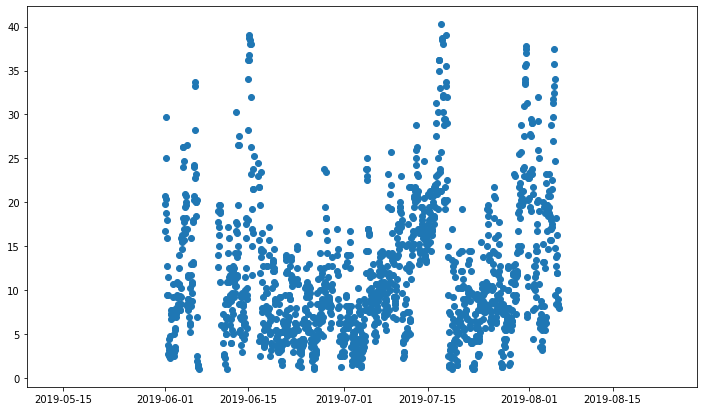

In [19]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.scatter(df3mean['time'], df3mean['pm2.5'])

In [20]:
df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)

In [21]:
df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)

In [22]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1
0,6,1,0,5.0,0.375000,12.750000,16.750000,18.500000,26.000000,70.250000,2019-05-31 23:54:00+08:00,20.750000,2019-06-01 00:54:00+08:00
1,6,1,1,5.0,1.375000,15.000000,20.750000,21.750000,26.000000,71.250000,2019-06-01 00:54:00+08:00,19.800000,2019-06-01 01:54:00+08:00
2,6,1,2,5.0,2.496667,14.000000,19.800000,21.000000,26.000000,71.000000,2019-06-01 01:54:00+08:00,20.333333,2019-06-01 02:54:00+08:00
3,6,1,3,5.0,3.483333,14.000000,20.333333,21.666667,25.666667,75.666667,2019-06-01 02:54:00+08:00,29.666667,2019-06-01 03:54:00+08:00
4,6,1,4,5.0,4.733333,20.333333,29.666667,31.333333,24.000000,91.666667,2019-06-01 03:54:00+08:00,25.000000,2019-06-01 04:54:00+08:00


In [23]:
# check the next row is the next hour or not. 
# If it is not, the `pm2.5_next_hour` column will be given NaN.

def check_next_hour(x):
    one_hour = dt.timedelta(hours=1)
    if x[2] - x[1] == one_hour:
        return x[0]
    return np.nan

df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)

In [24]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1,pm2.5_next_hour
0,6,1,0,5.0,0.375000,12.750000,16.750000,18.500000,26.000000,70.250000,2019-05-31 23:54:00+08:00,20.750000,2019-06-01 00:54:00+08:00,20.750000
1,6,1,1,5.0,1.375000,15.000000,20.750000,21.750000,26.000000,71.250000,2019-06-01 00:54:00+08:00,19.800000,2019-06-01 01:54:00+08:00,19.800000
2,6,1,2,5.0,2.496667,14.000000,19.800000,21.000000,26.000000,71.000000,2019-06-01 01:54:00+08:00,20.333333,2019-06-01 02:54:00+08:00,20.333333
3,6,1,3,5.0,3.483333,14.000000,20.333333,21.666667,25.666667,75.666667,2019-06-01 02:54:00+08:00,29.666667,2019-06-01 03:54:00+08:00,29.666667
4,6,1,4,5.0,4.733333,20.333333,29.666667,31.333333,24.000000,91.666667,2019-06-01 03:54:00+08:00,25.000000,2019-06-01 04:54:00+08:00,25.000000


In [25]:
df3mean.isna().sum()

month               0
day                 0
hour                0
weekday             0
hour_minute         0
pm1.0               0
pm2.5               0
pm10.0              0
temp                0
humidity            0
time                0
pm2.5_shift-1       1
time_shift-1        1
pm2.5_next_hour    10
dtype: int64

In [26]:
# Discard rows that contain NaN value
df3mean.dropna(inplace=True)

In [27]:
df3mean.isna().sum()

month              0
day                0
hour               0
weekday            0
hour_minute        0
pm1.0              0
pm2.5              0
pm10.0             0
temp               0
humidity           0
time               0
pm2.5_shift-1      0
time_shift-1       0
pm2.5_next_hour    0
dtype: int64

### Normalization

$z = \frac{x- \mu}{\sigma}$


In [28]:
# Save time infomation in another df, and discard it
df3mean_time = df3mean['time_shift-1']
df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
# Normalization
df3mean = (df3mean - df3mean.mean()) / df3mean.std()

### Divid training set and test set

In [29]:
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

In [30]:
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

test_df_time = df3mean_time[four_fifth_len:]

In [31]:
X = train_df[['month', 'day', 'weekday', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
y = train_df[['pm2.5_next_hour']]

In [32]:
test_X = test_df[['month', 'day', 'weekday', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_y = test_df[['pm2.5_next_hour']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [33]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [34]:
# See the coefficients of our model
a = model.coef_
b = model.intercept_
print(a)
print(b)

[[ 0.01252273 -0.01518742 -0.00645569  0.0263951   0.08476088  0.73650037
   0.09322293 -0.07056569 -0.07112976]]
[-0.00548781]


In [35]:
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))

Coefficient for      month:	0.0125227284744696
Coefficient for        day:	-0.01518741510588546
Coefficient for    weekday:	-0.006455687857015489
Coefficient for hour_minute:	0.026395103856870786
Coefficient for      pm1.0:	0.08476088033934276
Coefficient for      pm2.5:	0.7365003659182927
Coefficient for     pm10.0:	0.09322292601709033
Coefficient for       temp:	-0.07056568900346293
Coefficient for   humidity:	-0.0711297612669089


In [36]:
# Calculate mean squared error for training set & test set
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.15932508130110118
Test MSE:	 0.253487989992304


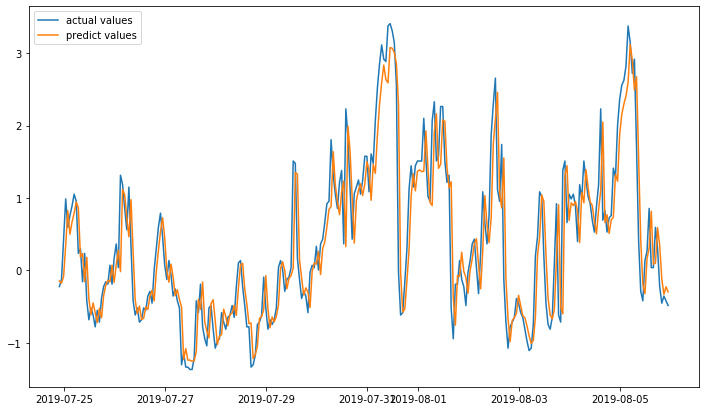

In [37]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [38]:
# Define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [39]:
# Define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=0.04, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())

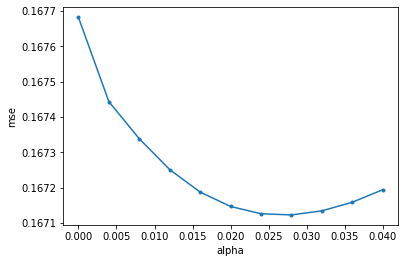

In [40]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [41]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.028

In [42]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

Ridge(alpha=0.028, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [43]:
# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))

Coefficient for      month:	0.00500061084425084
Coefficient for        day:	-0.02173313755108519
Coefficient for    weekday:	-0.00529899183429663
Coefficient for hour_minute:	0.022459093853804023
Coefficient for      pm1.0:	0.28389900955957686
Coefficient for      pm2.5:	0.34263889697603583
Coefficient for     pm10.0:	0.28329943364422394
Coefficient for       temp:	-0.050305823588231574
Coefficient for   humidity:	-0.051419472875128366


In [44]:
# Calculate mean squared error for training set & test set
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.16006237397722722
Test MSE:	 0.25474561398045836


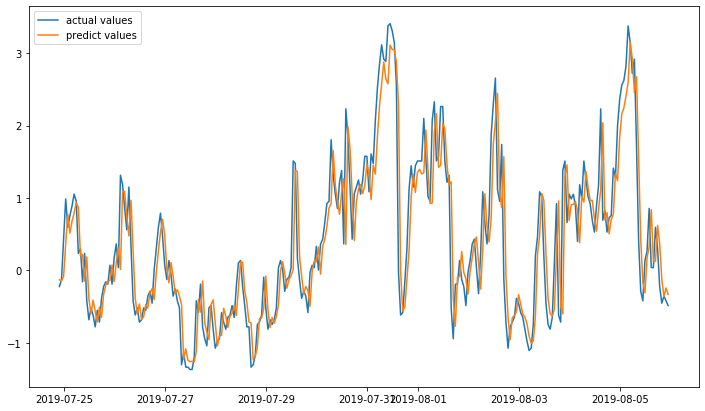

In [45]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection by myself

In [46]:
# Select features I want
X_fsm = X[['pm2.5', 'temp', 'humidity']]
test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]

In [47]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X_fsm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [48]:
# See the coefficients of our model
for i in range(len(X_fsm.columns)):
    print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))

Coefficient for      pm2.5:	0.910943486471618
Coefficient for       temp:	-0.05550473626297474
Coefficient for   humidity:	-0.05700359269719747


In [49]:
# Calculate mean squared error for training set & test set
predict_train_y = model.predict(X_fsm)
predict_y = model.predict(test_X_fsm)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.16052911306316844
Test MSE:	 0.2544104563388273


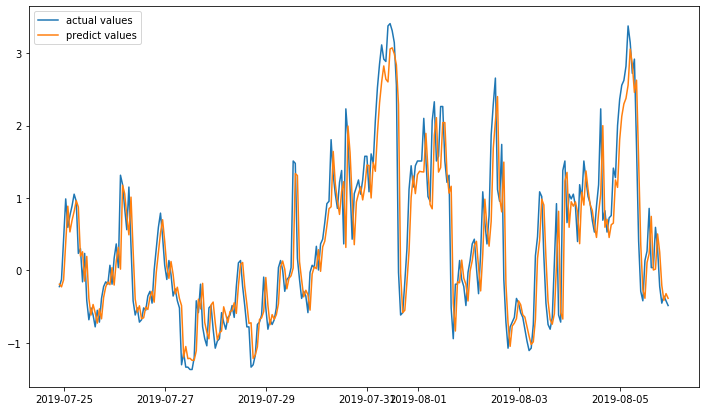

In [50]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

### Do Ridge Regression again

### All in one

將所有步驟寫成一個 function 。


In [51]:
'''
# Load data
data3 = get_data_by_pos(7)
df3 = pd.DataFrame(data3)
# Input time
time = ['2019 06 01', '2019 08 06']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Exclude outliers
want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`
df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)
df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)
# Check the next row is the next hour or not. 
# If it is not, the `pm2.5_next_hour` column will be given NaN.
df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)
# discard rows that contain NaN value
df3mean.dropna(inplace=True)
# Normalization
df3mean_time = df3mean['time_shift-1']
df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)

df3mean = (df3mean - df3mean.mean()) / df3mean.std()
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

test_df_time = df3mean_time[four_fifth_len:]

X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
y = train_df[['pm2.5_next_hour']]

test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_y = test_df[['pm2.5_next_hour']]
# define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=0.03, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())
best_alpha = alphas[np.argmin(mses)]
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

# See the coefficients of our model
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))
# Calculate mean squared error for training set & test set    
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# Plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()
'''

"\n# Load data\ndata3 = get_data_by_pos(7)\ndf3 = pd.DataFrame(data3)\n# Input time\ntime = ['2019 06 01', '2019 08 06']\ntaipei_tz = pytz.timezone('Asia/Taipei')\n# Set time\nstart_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)\nend_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)\n# Select the duration\ndf3 = df3.loc[ df3['date'] >= start_time ]\ndf3 = df3.loc[ df3['date'] <= end_time ]\n# Rename the names of columns\ndf3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})\n# Exclude outliers\nwant_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']\ndf3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]\n# Split time infomation from column `date`\ndf3['month'] = df3['date'].apply(lambda x: x.month)\ndf3['day'] = df3['date'].apply(lambda x: x.day)\ndf3['weekday'] = df3['date'].apply(lambda x: x.weekday)\ndf3['hour'] = df3['date'].apply(lambda x: x.hour)\ndf3['hour_minute'] = df3['dat

In [52]:
def predict(pos):    
    # Load data
    data3 = get_data_by_pos(pos)
    df3 = pd.DataFrame(data3)
    # Input time
    time = ['2019 06 01', '2019 08 06']
    taipei_tz = pytz.timezone('Asia/Taipei')
    # Set time
    start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
    end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
    # Select the duration
    df3 = df3.loc[ df3['date'] >= start_time ]
    df3 = df3.loc[ df3['date'] <= end_time ]
    # Rename the names of columns
    df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
    # Exclude outliers
    want_cols = ['humidity', 'pm1.0', 'pm10.0', 'pm2.5', 'temp']
    df3 = df3[(np.abs(stats.zscore(df3.loc[:, want_cols])) < 4).all(axis=1)]
    # Split time infomation from column `date`
    df3['month'] = df3['date'].apply(lambda x: x.month)
    df3['day'] = df3['date'].apply(lambda x: x.day)
    df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
    df3['hour'] = df3['date'].apply(lambda x: x.hour)
    df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
    # Set the order of the columns & discard some columns
    df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    # Evaluate mean values for each hour
    df3mean = df3.groupby(['month', 'day', 'hour']).mean()
    df3mean.reset_index(inplace=True)
    # Reconstruct time infomation by `month`, `day`, and `hour`
    df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)
    df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)
    df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)
    # Check the next row is the next hour or not. 
    # If it is not, the `pm2.5_next_hour` column will be given NaN.
    df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)
    # discard rows that contain NaN value
    df3mean.dropna(inplace=True)
    # Save time infomation in another df, and discard it
    df3mean_time = df3mean['time_shift-1']
    df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)
    # Normalization
    df3mean = (df3mean - df3mean.mean()) / df3mean.std()
    # Divid training set and test set
    four_fifth_len = len(df3mean)*0.8
    four_fifth_len = int(four_fifth_len)

    train_df = df3mean[:four_fifth_len]
    test_df = df3mean[four_fifth_len:]

    test_df_time = df3mean_time[four_fifth_len:]

    X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    y = train_df[['pm2.5_next_hour']]

    test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
    test_y = test_df[['pm2.5_next_hour']]
    # Select features I want
    X_fsm = X[['pm2.5', 'temp', 'humidity']]
    test_X_fsm = test_X[['pm2.5', 'temp', 'humidity']]
    # Fit the model
    model = linear_model.LinearRegression(normalize=True)
    model.fit(X_fsm, y)
    # See the coefficients of our model
    for i in range(len(X_fsm.columns)):
        print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))
    # Calculate mean squared error for training set & test set
    predict_train_y = model.predict(X_fsm)
    predict_y = model.predict(test_X_fsm)

    train_mse = metrics.mean_squared_error(y, predict_train_y)
    test_mse = metrics.mean_squared_error(test_y, predict_y)

    print('Train MSE:\t %s' % train_mse)
    print('Test MSE:\t %s' % test_mse)
    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()

    # Plt
    plt.figure(figsize=(12, 7))
    plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
    plt.plot(test_df_time, predict_y, label='predict values')
    plt.legend()
    plt.show()

Coefficient for      pm2.5:	0.9313903213124722
Coefficient for       temp:	-0.06694487505652261
Coefficient for   humidity:	-0.0641465351848132
Train MSE:	 0.1242282222726783
Test MSE:	 0.2795054196545553


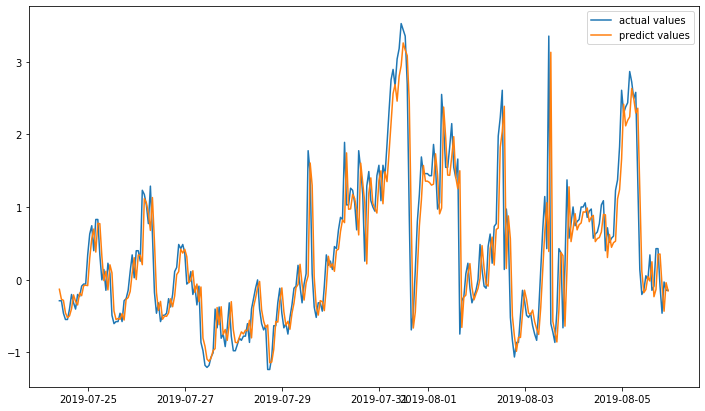

In [53]:
predict(5)

## 不區分 Position 的 Linear Regression

未完成...

### Load data


In [54]:
data = get_all_data()

In [55]:
df = pd.DataFrame(data)

### Data preprocessing

In [56]:
# rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [57]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29


In [58]:
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday'] = df['date'].apply(lambda x: x.weekday)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['hour_minute'] = df['date'].apply(lambda x: x.hour+x.minute/60)

In [59]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28,5,11,5,9,9.466667
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27,5,11,5,9,9.483333
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29,5,11,5,9,9.716667
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27,5,11,5,9,9.733333
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29,5,11,5,9,9.966667


In [60]:
df.drop(columns=['_cls', 'date'], inplace=True)
df.head()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,62,50,94,78,3,28,5,11,5,9,9.466667
1,67,42,81,72,5,27,5,11,5,9,9.483333
2,61,36,71,60,3,29,5,11,5,9,9.716667
3,67,41,82,70,5,27,5,11,5,9,9.733333
4,59,39,75,63,3,29,5,11,5,9,9.966667


In [61]:
df[['pm2.5_next']] = df[['pm2.5']].shift(-1)

In [62]:
df.dropna(inplace=True)
df.tail()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute,pm2.5_next
50035,68,8,16,11,5,28,8,5,0,23,23.300000,11.0
50036,68,7,11,11,6,27,8,5,0,23,23.316667,12.0
50037,73,9,12,12,1,26,8,5,0,23,23.316667,11.0
50038,74,7,11,11,4,26,8,5,0,23,23.333333,7.0
50039,64,6,7,7,2,28,8,5,0,23,23.400000,10.0


In [63]:
four_fifth_len = len(df)*0.8
four_fifth_len = int(four_fifth_len)

In [64]:
train_df = df[:four_fifth_len]
test_df = df[four_fifth_len:]

In [65]:
X = train_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
y = train_df[['pm2.5_next']]

In [66]:
test_X = test_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
test_y = test_df[['pm2.5_next']]